Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
# Importing necessary libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [2]:
# mounting the google drive

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
# path for train and test images

data_dir_train = pathlib.Path('/content/gdrive/MyDrive/cnn_assignment/image_data/Train/')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/cnn_assignment/image_data/Test/')


In [46]:
# Count the total images in train and test data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset



In [7]:
# Define some image parameters
batch_size = 32
img_height = 180
img_width = 180

In [49]:
# create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [50]:
# create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [51]:
# all classes of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### One instance of all the nine classes present in the dataset

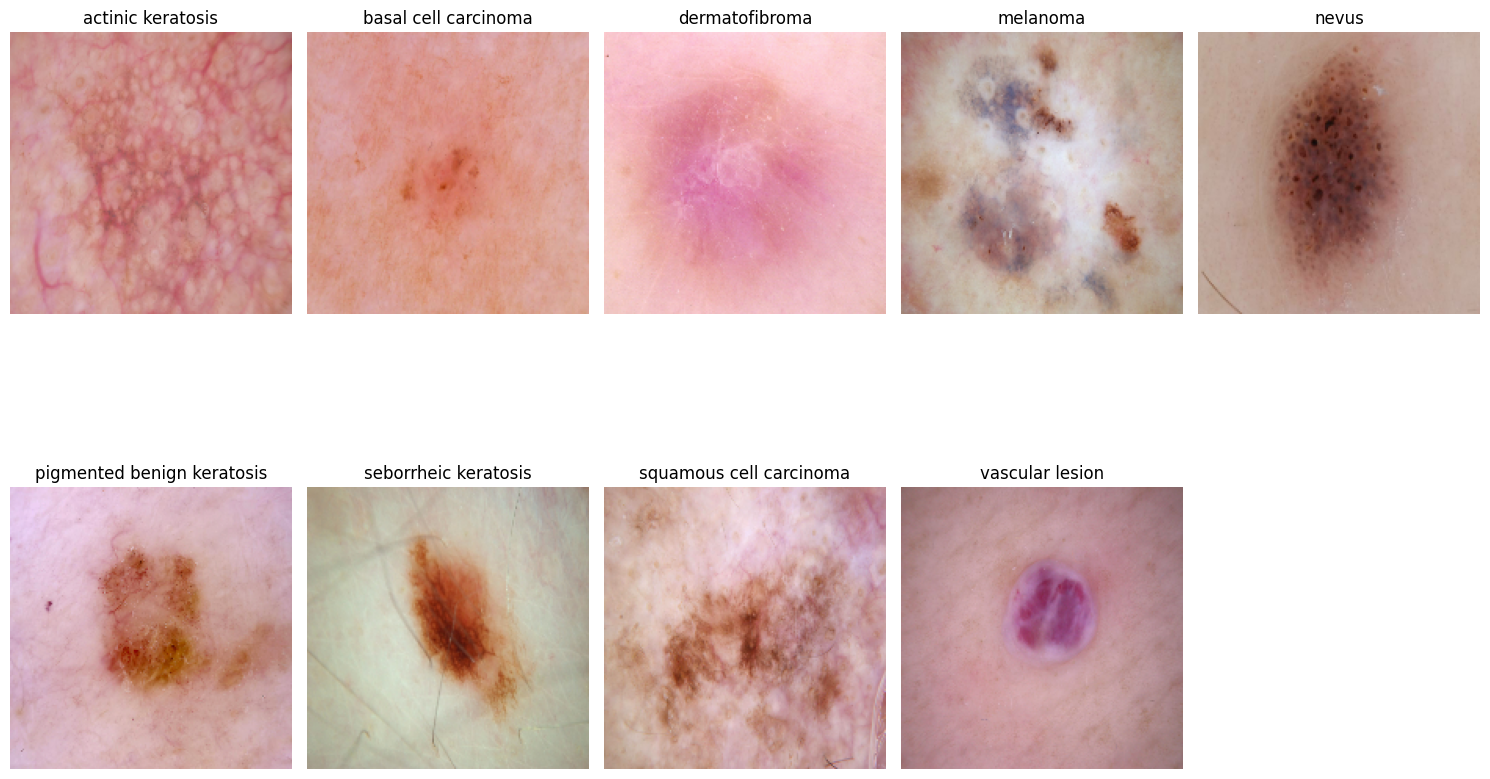

In [11]:
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
        # Get one image from each class
        for images, labels in train_ds:
            # Find the index of the current class
            index = np.where(labels.numpy() == i)[0]
            if len(index) > 0:
                plt.subplot(2, 5, i + 1)
                plt.imshow(images[index[0]].numpy().astype("uint8"))
                plt.title(class_name)
                plt.axis('off')
                break
plt.tight_layout()
plt.show()


In [52]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [53]:
# Normalize pixel values
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Build CNN model
model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),

    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')

])

### Compile the model


In [54]:
# Compling the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [55]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [56]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - accuracy: 0.2068 - loss: 2.1010 - val_accuracy: 0.3647 - val_loss: 1.7274
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3526 - loss: 1.7413 - val_accuracy: 0.4295 - val_loss: 1.6227
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4477 - loss: 1.5149 - val_accuracy: 0.4743 - val_loss: 1.5058
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5027 - loss: 1.4029 - val_accuracy: 0.4430 - val_loss: 1.4841
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5098 - loss: 1.3490 - val_accuracy: 0.5481 - val_loss: 1.3267
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5609 - loss: 1.2001 - val_accuracy: 0.5459 - val_loss: 1.3129
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6270 - loss: 1.0744 - val_accuracy: 0.5682 - val_loss: 1.2511
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6243 - loss: 1.0312 - val_accuracy: 0.5369 -

### Visualizing training results

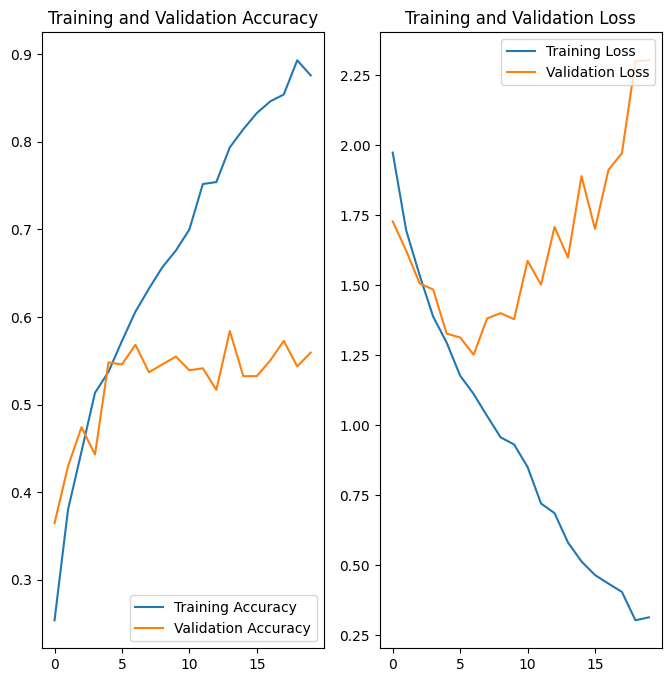

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Fndings from above model

##### The model's training accuracy shows a steady increase of upto 90%, while validation accuracy remains consistently around 55%.

A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

### Creating model again to overcome overfitting problem


In [58]:
# Normalize pixel values
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Build CNN model
model = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')

])



### Compiling the model

In [59]:
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [60]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.1668 - loss: 2.0849 - val_accuracy: 0.2058 - val_loss: 2.0307
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2091 - loss: 2.0097 - val_accuracy: 0.2058 - val_loss: 2.0320
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1962 - loss: 2.0121 - val_accuracy: 0.2058 - val_loss: 2.0353
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2010 - loss: 2.0234 - val_accuracy: 0.2058 - val_loss: 2.0470
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.1866 - loss: 2.0352 - val_accuracy: 0.2058 - val_loss: 2.0243
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2035 - loss: 2.0081 - val_accuracy: 0.2058 - val_loss: 2.0257
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2131 - loss: 2.0240 - val_accuracy: 0.2058 - val_loss: 2.0260
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2022 - loss: 2.0114 - val_accuracy: 0.2058 - v

### Visualizing the results

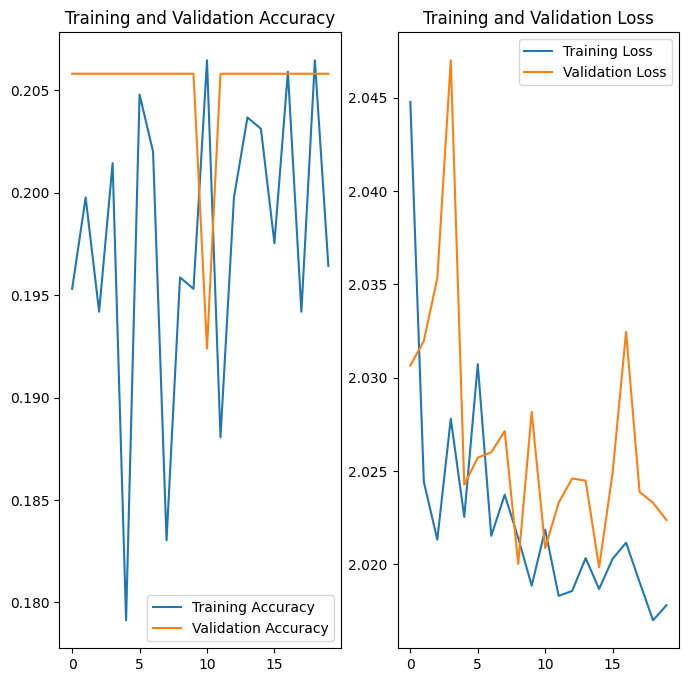

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings of above model
#### After augmented data, overfitting has been effectively addressed. The training and validation accuracy of the model fall within a similar range.Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.



## Creating new model by handling class imbalance to increase model accuracy

Class: actinic keratosis, Count: 92
Class: basal cell carcinoma, Count: 309
Class: dermatofibroma, Count: 77
Class: melanoma, Count: 352
Class: nevus, Count: 277
Class: pigmented benign keratosis, Count: 370
Class: seborrheic keratosis, Count: 58
Class: squamous cell carcinoma, Count: 142
Class: vascular lesion, Count: 115


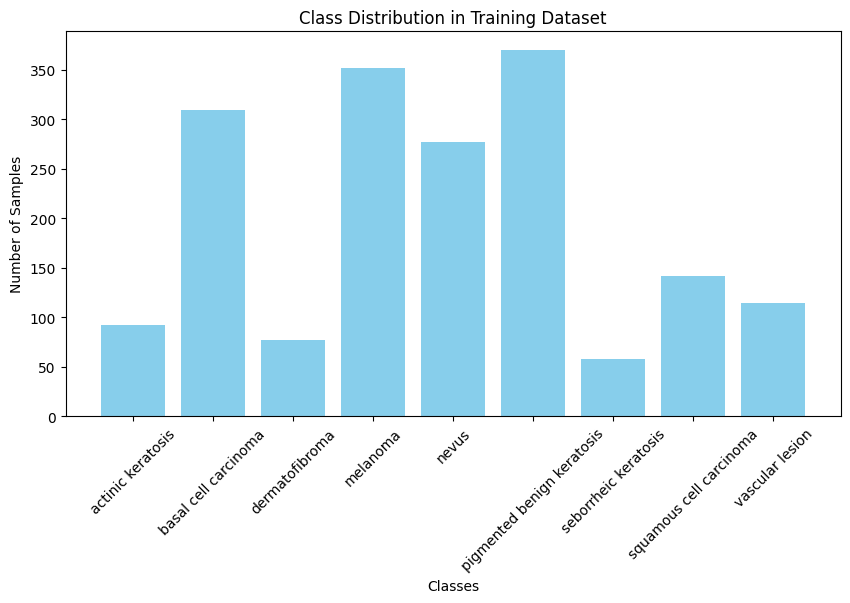

In [23]:
# Counting and display each class

# Count occurrences of each class
class_counts = [0] * len(class_names)

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1

# Display class distribution
for class_name, count in zip(class_names, class_counts):
    print(f'Class: {class_name}, Count: {count}')

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.show()

## Class 'pigmented benign keratosis' has highest number of samples : 370, and Class 'seborrheic keratosis' has lowest number of samples : 58

In [25]:
pip install Augmentor

In [62]:
# Generating samples using augmentor library
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train / i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn_assignment/image_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7974DCE9CA30>: 100%|██████████| 500/500 [00:19<00:00, 26.22 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn_assignment/image_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7974DCDAB7F0>: 100%|██████████| 500/500 [00:20<00:00, 24.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn_assignment/image_data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7974DCD38910>: 100%|██████████| 500/500 [00:19<00:00, 25.01 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn_assignment/image_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7974DCD73220>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn_assignment/image_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7974DCD711E0>: 100%|██████████| 500/500 [01:23<00:00,  5.99 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn_assignment/image_data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7974DD7B7EB0>: 100%|██████████| 500/500 [00:20<00:00, 24.36 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn_assignment/image_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79756735AAA0>: 100%|██████████| 500/500 [00:41<00:00, 12.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn_assignment/image_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79748B79D0C0>: 100%|██████████| 500/500 [00:21<00:00, 22.91 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn_assignment/image_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7974DCE1B3D0>: 100%|██████████| 500/500 [00:19<00:00, 25.73 Samples/s]


In [63]:
# Counting number of images after augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [64]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/MyDrive/cnn_assignment/image_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_3269ebb7-fbec-4a6d-bd8b-177d91cef962.jpg',
 '/content/gdrive/MyDrive/cnn_assignment/image_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_886e44b5-4079-4a18-8f03-221fe0840d25.jpg',
 '/content/gdrive/MyDrive/cnn_assignment/image_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_31aa614e-234a-469b-9a9b-3fbf86566fdc.jpg',
 '/content/gdrive/MyDrive/cnn_assignment/image_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032135.jpg_db973512-1cec-4dda-aa52-684dae7174d1.jpg',
 '/content/gdrive/MyDrive/cnn_assignment/image_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_3c62b2df-d265-4f81-9438-408c1e5a2420.jpg']

In [65]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [66]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


In [67]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
df2.shape

(4500, 2)

In [68]:
# View the augmented image paths and labels in a new df
df2.head()

,Image Path,Label
0,/content/gdrive/MyDrive/cnn_assignment/image_d...,actinic keratosis
1,/content/gdrive/MyDrive/cnn_assignment/image_d...,actinic keratosis
2,/content/gdrive/MyDrive/cnn_assignment/image_d...,actinic keratosis
3,/content/gdrive/MyDrive/cnn_assignment/image_d...,actinic keratosis
4,/content/gdrive/MyDrive/cnn_assignment/image_d...,actinic keratosis


In [69]:
# Inspecting the classes after adding 500 samples per label
df2['Label'].value_counts()

,count
Label,
actinic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500
vascular lesion,500


In [70]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(df2['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
actinic keratosis,11.11
basal cell carcinoma,11.11
dermatofibroma,11.11
melanoma,11.11
nevus,11.11
pigmented benign keratosis,11.11
seborrheic keratosis,11.11
squamous cell carcinoma,11.11
vascular lesion,11.11


In [71]:
# path for train and test images

data_dir_train = pathlib.Path('/content/gdrive/MyDrive/cnn_assignment/image_data/Train/')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/cnn_assignment/image_data/Test/')


In [72]:
# Definig the train parameters
batch_size = 32
img_height = 180
img_width = 180

In [73]:
# Create a training dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [74]:
# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [75]:
## your code goes here
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Build CNN model
model = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    layers.Conv2D(16, (3, 3),padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model

In [76]:
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [77]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 261ms/step - accuracy: 0.1631 - loss: 2.1867 - val_accuracy: 0.3437 - val_loss: 1.7603
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.4021 - loss: 1.5851 - val_accuracy: 0.4417 - val_loss: 1.4360
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 266ms/step - accuracy: 0.4552 - loss: 1.4421 - val_accuracy: 0.4796 - val_loss: 1.4008
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 240ms/step - accuracy: 0.4877 - loss: 1.3441 - val_accuracy: 0.5427 - val_loss: 1.1904
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.5194 - loss: 1.2729 - val_accuracy: 0.5219 - val_loss: 1.2848
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.5429 - loss: 1.2087 - val_accuracy: 0.5457 - val_loss: 1.1576
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 254ms/step - accuracy: 0.5600 - loss: 1.1556 - val_accuracy: 0.5709 - val_loss: 1.1393
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.5762 - loss: 1

### Visualize the model results

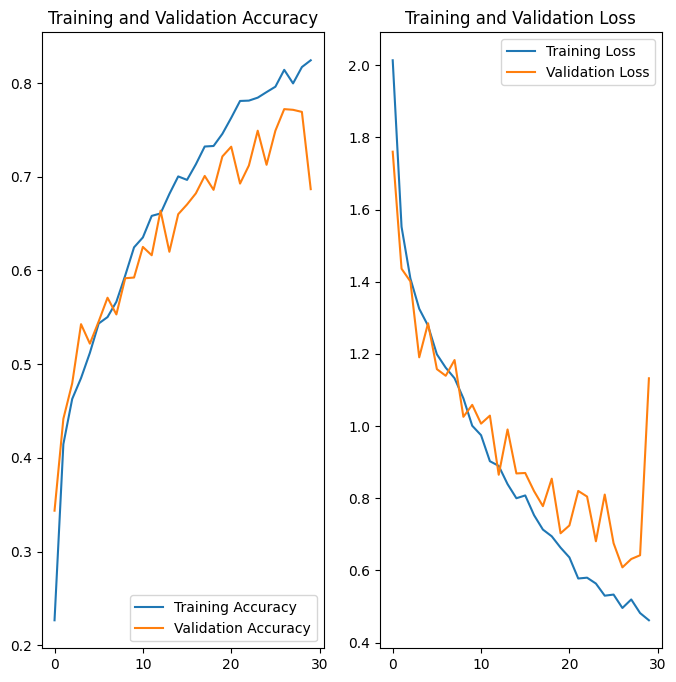

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:

The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

Following 30 epochs, the final model attains an accuracy of 81% on the training set and approximately 76% on the validation set.

The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

